The pricing json files for VM and disks can be downloaded fron the following links. 

VM link:
https://azure.microsoft.com/api/v3/pricing/virtual-machines/calculator/?discount=mosp&showSkus=true&showGuids=true&currency=eur

Disks link:
https://azure.microsoft.com/api/v2/pricing/managed-disks/calculator/?culture=en-us&discount=mosp&showSkus=true&showGuids=true&currency=eur

Site Recovery link:
https://azure.microsoft.com/api/v2/pricing/site-recovery/calculator/?culture=en-us&discount=mosp&showSkus=true&showGuids=true&currency=eur

If, before downloading the files, you open the azure calculator at https://azure.microsoft.com/en-us/pricing/calculator/ and login to the platform, the json will also include a column reporting the sku number (if you don't login, the column with sku will not be included in the json). 

To download the files, please open the above link and save the resulting json in the working folder (in the same folder as this notebook) with names "vm_pricing_table.json" and "disk_pricing_table.json"

In [1]:
import pandas as pd
import json
import re
import traceback
import math
import os

The following lines are to open and prepare the input files

In [2]:

with open(os.path.join('.','data', 'vm_pricing_table.json')) as f:
    vm_pricing_table = json.load(f)
    
vm_pricing_table_offers = vm_pricing_table['offers']
vm_pricing_table_offers = pd.DataFrame(vm_pricing_table_offers).T

In [3]:
with open(os.path.join('.','data','disk_pricing_table.json')) as f:
    disk_pricing_table = json.load(f)

disk_pricing_table_offers = disk_pricing_table['offers']
disk_pricing_table_offers = pd.DataFrame(disk_pricing_table_offers).T

In [4]:
with open(os.path.join('.','data','site_recovery_pricing_table.json')) as f:
    site_recovery_pricing_table = json.load(f)

site_recovery_pricing_offers = site_recovery_pricing_table['offers']['recover-to-azure']
site_recovery_pricing_offers = pd.DataFrame(site_recovery_pricing_offers)

In [5]:
# cleaning the imported json files from data that are not needed and which would create issues
disk_pricing_table_offers.reset_index(inplace=True)
disk_pricing_table_offers.rename(columns = {'index':'diskName'}, inplace = True)
disk_pricing_table_offers = disk_pricing_table_offers[~disk_pricing_table_offers['diskName'].str.match('.*mount.*')]

vm_pricing_table_offers.reset_index(inplace=True)
vm_pricing_table_offers.rename(columns = {'index':'vmName'}, inplace = True)
vm_pricing_table_offers = vm_pricing_table_offers[~vm_pricing_table_offers['vmName'].str.match('.*lowpriority.*')]

In [6]:
# reading the input BOM file
input_bom = pd.read_excel(os.path.join('.','inputs','input_bom.xlsx'))
# input_bom = input_bom[pd.to_numeric(input_bom['coresReq'], errors='coerce')>0]

In [7]:
# reading the discount file (this file includes sku codes and associated discounts)
input_sku_discount = pd.read_excel(os.path.join('.','inputs','input_sku_discounts.xlsx'))
input_sku_discount.set_index('sku', inplace=True)
discount_default_payg = input_sku_discount.loc['default_payg']['discount']
discount_default_reserved = input_sku_discount.loc['default_reserved']['discount']

The following functions are needed to extract key values from the json file. These functions will be used in Pandas dataframe apply statements

In [8]:
# preparing fuctions to extract values row by row from the json files.
def discount(sku_string: str):
    try:
        return input_sku_discount.loc[sku_string]['discount']
    except:
        return discount_default_payg

def extract_price_disk(row: pd.Series, region: str):
    try:
        return row['prices'][region]['value']
    except:
        return None

def extract_price_payg(row: pd.Series, region: str):
    try:
        return row['prices']['perhour'][region]['value']
    except:
        return None

def extract_price_3yr(row: pd.Series, region: str):
    try:
        return row['prices']['perhourthreeyearreserved'][region]['value']
    except:
        return None

def extract_price_1yr(row: pd.Series, region: str):
    try:
        return row['prices']['perhouroneyearreserved'][region]['value']
    except:
        return None

def extract_sku(row: pd.Series, region: str):
    try:
        return row['partNumbers'][region]['sku']
    except:
        return None

def extract_redhat_sku_payg(row: pd.Series, region: str):
    try:
        return row['partNumbers']['global']['sku']
    except:
        return None

def extract_redhat_price_payg(row: pd.Series, region: str):
    try:
        return row['prices']['perhour']['global']['value']
    except:
        return None

def extract_redhat_price_res1y(row: pd.Series, region: str):
    try:
        return row['prices']['perhouroneyearreserved']['global']['value']
    except:
        return None

The following loop is reading line by line the BOM and, for each row, is finding the machine and disk that satisfy the input conditions (requested vcpu, ram, ...) and cost less. The algorithm is simply taking the price list sorted by price, filtering it by the input conditions, and taking the first entry, which has the lowest price.
For disks, a slightly moore complex logic in implemented because multiple disk can be used in striping. A striping of multiple disks may better fit the requirements (e.g. if requirement is for 90 GB, then three 32 GB disks in striping will cost less than one 128 GB disk). A table of available disk size and striping combination is created. This table depend on the max number of disks that are allowed in striping, which is an input, and is constructed by combining the base sizes (4, 8, 16, 32, ...) multiplied by the possible number of disks (1, 2, 3, ..., max) up to the maximum defined. After this table is created, it is sorted, and the smallest combination that satisfies the customer need is identified. This combination is then quoted searching on the price list.

In [9]:
# preparign a table of possible disk sizes which is used in the loop below to select the best combination of disks
disk_sizes = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32767]
disk_sizes = pd.DataFrame(disk_sizes, columns=["size"])
disk_sizes['units'] = 1

In [10]:
output = []
region = ''
disk_max_num = 0
error_message_stage = "stage: 0"
for row in input_bom.itertuples():
    row_dict = row._asdict()

    if row.do_compute == "yes":
        if region != row.region:
            region = row.region
            print(f'using region: {region}')

            vm_pricing_table_offers_payg = vm_pricing_table_offers.copy()
            vm_pricing_table_offers_payg['priceVM'] = vm_pricing_table_offers_payg.apply(lambda row: extract_price_payg(row, region), axis=1)
            vm_pricing_table_offers_payg['skuVM'] = vm_pricing_table_offers_payg.apply(lambda row: extract_sku(row, region), axis=1)
            vm_pricing_table_offers_payg.drop(['prices', 'partNumbers'], axis=1, inplace=True)
            vm_pricing_table_offers_payg = vm_pricing_table_offers_payg.join(input_sku_discount,on='skuVM')
            vm_pricing_table_offers_payg['discount'] = vm_pricing_table_offers_payg['discount'].fillna(discount_default_payg)
            vm_pricing_table_offers_payg.rename(columns = {'discount':'discountVm'}, inplace = True)
            vm_pricing_table_offers_payg['priceVmDiscounted'] = vm_pricing_table_offers_payg['priceVM'] * (1-vm_pricing_table_offers_payg['discountVm'])
            vm_pricing_table_offers_payg['sortMetric_pricePlusHiddenLicense'] = vm_pricing_table_offers_payg['priceVmDiscounted'] + vm_pricing_table_offers_payg['cores'] * row.hiddenLicenseCost
            vm_pricing_table_offers_payg.sort_values('sortMetric_pricePlusHiddenLicense', inplace=True)

            vm_pricing_table_offers_3y = vm_pricing_table_offers.copy()
            vm_pricing_table_offers_3y['priceVM'] = vm_pricing_table_offers_3y.apply(lambda row: extract_price_3yr(row, region), axis=1)
            vm_pricing_table_offers_3y['skuVM'] = vm_pricing_table_offers_3y.apply(lambda row: extract_sku(row, region), axis=1)
            vm_pricing_table_offers_3y.drop(['prices', 'partNumbers'], axis=1, inplace=True)
            vm_pricing_table_offers_3y['discount'] = discount_default_reserved
            vm_pricing_table_offers_3y.rename(columns = {'discount':'discountVm'}, inplace = True)
            vm_pricing_table_offers_3y['priceVmDiscounted'] = vm_pricing_table_offers_3y['priceVM'] * (1-vm_pricing_table_offers_3y['discountVm'])
            vm_pricing_table_offers_3y['sortMetric_pricePlusHiddenLicense'] = vm_pricing_table_offers_3y['priceVmDiscounted'] + vm_pricing_table_offers_3y['cores'] * row.hiddenLicenseCost
            vm_pricing_table_offers_3y.sort_values('sortMetric_pricePlusHiddenLicense', inplace=True)

            disk_pricing_table_offers_w = disk_pricing_table_offers.copy()
            disk_pricing_table_offers_w['priceDisk'] = disk_pricing_table_offers_w.apply(lambda row: extract_price_disk(row, region), axis=1)
            disk_pricing_table_offers_w['skuDisk'] = disk_pricing_table_offers_w.apply(lambda row: extract_sku(row, region), axis=1)
            disk_pricing_table_offers_w.drop(['prices', 'partNumbers'], axis=1, inplace=True)
            disk_pricing_table_offers_w = disk_pricing_table_offers_w.join(input_sku_discount,on='skuDisk')
            disk_pricing_table_offers_w['discount'] = disk_pricing_table_offers_w['discount'].fillna(discount_default_payg)
            disk_pricing_table_offers_w.rename(columns = {'discount':'discountDisk'}, inplace = True)
            disk_pricing_table_offers_w['priceDiskDiscounted'] = disk_pricing_table_offers_w['priceDisk'] * (1-disk_pricing_table_offers_w['discountDisk'])
            disk_pricing_table_offers_w.sort_values('priceDiskDiscounted', inplace=True)

            vm_pricing_table_offers_redhat = vm_pricing_table_offers.copy()
            vm_pricing_table_offers_redhat = vm_pricing_table_offers_redhat[vm_pricing_table_offers_redhat['vmName'].str.match(r'redhat-[0-9]+.*core')]
            vm_pricing_table_offers_redhat['priceRedHatPayg'] = vm_pricing_table_offers_redhat.apply(lambda row: extract_redhat_price_payg(row, region), axis=1)
            vm_pricing_table_offers_redhat['priceRedHatRes1y'] = vm_pricing_table_offers_redhat.apply(lambda row: extract_redhat_price_res1y(row, region), axis=1)
            vm_pricing_table_offers_redhat['skuRedHat'] = vm_pricing_table_offers_redhat.apply(lambda row: extract_redhat_sku_payg(row, region), axis=1)
            vm_pricing_table_offers_redhat = vm_pricing_table_offers_redhat[['vmName', 'cores', 'priceRedHatPayg', 'priceRedHatRes1y', 'skuRedHat']]
            vm_pricing_table_offers_redhat.sort_values('cores', inplace=True)
        
        # select best vm reserved 3y
        try:
            if not (row.coresReq > 0 and row.ramReq > 0):
                raise Exception('VM data is missing')

            error_message_stage = "stage: 1"
            ptable = vm_pricing_table_offers_3y.copy()
            ptable = ptable[ptable['cores'] >= row.coresReq]
            ptable = ptable[ptable['ram'] >= row.ramReq]
            ptable = ptable[ptable['vmName'].str.match(row.regexVm)]
            ptable = ptable[ptable['skuVM'].notnull()]
            selected_vm = dict(ptable.iloc[0].add_suffix("_res3y"))
            row_dict.update(selected_vm)

            error_message_stage = "stage: 2"
            ptable = vm_pricing_table_offers_payg.copy()
            ptable = ptable[ptable['cores'] >= row.coresReq]
            ptable = ptable[ptable['ram'] >= row.ramReq]
            ptable = ptable[ptable['vmName'].str.match(row.regexVm)]
            ptable = ptable[ptable['skuVM'].notnull()]
            selected_vm = dict(ptable.iloc[0].add_suffix("_payg"))
            row_dict.update(selected_vm)

            error_message_stage = "stage: 2 win"
            ptable = vm_pricing_table_offers_payg.copy()
            ptable = ptable[ptable['cores'] >= row.coresReq]
            ptable = ptable[ptable['ram'] >= row.ramReq]
            ptable = ptable[ptable['vmName'].str.match('windows')]
            ptable = ptable[ptable['vmName'].str.match(row.regexVm)]
            ptable = ptable[ptable['skuVM'].notnull()]
            #ptable = ptable[ptable['priceVM'].notnull()]
            selected_vm = dict(ptable.iloc[0].add_suffix("_payg_Windows"))
            row_dict.update(selected_vm)

            error_message_stage = "stage: 2 redhat"
            ptable = vm_pricing_table_offers_redhat.copy()
            ptable = ptable[ptable['cores'] >= row_dict['cores_payg']]
            ptable = ptable[ptable['skuRedHat'].notnull()]
            selected_vm = dict(ptable.iloc[0].add_suffix("_payg_RedHat"))
            row_dict.update(selected_vm)

            row_dict['windowsLicenseCores'] = 8 if (row_dict['cores_payg'] <= 8) else math.ceil(row_dict['cores_payg']/16) * 16

            error_message_stage = "stage: 3"
            # select best pricing model (payg vs reserved), and compute price per month 
            vm_cost_per_month_res3y = row_dict['priceVM_res3y'] * 730
            vm_cost_per_month_payg = row_dict['priceVM_payg'] * row.hoursPerMonth
            vm_cost_per_month_discounted_res3y = row_dict['priceVmDiscounted_res3y'] * 730
            vm_cost_per_month_discounted_payg = row_dict['priceVmDiscounted_payg'] * row.hoursPerMonth
            if(vm_cost_per_month_discounted_res3y < vm_cost_per_month_discounted_payg):
                row_dict['vmBestPricingModel'] = 'reserved3y'
                row_dict['VMcostPerMonth'] = vm_cost_per_month_res3y
                row_dict['VMcostPerMonthDiscounted'] = vm_cost_per_month_discounted_res3y
                row_dict['vmSelected'] = row_dict['vmName_res3y']
                row_dict['vmSkuSelected'] = row_dict['skuVM_res3y']
                row_dict['discountVm'] = row_dict['discountVm_res3y']
            else:
                row_dict['vmBestPricingModel'] = 'payg'
                row_dict['VMcostPerMonth'] = vm_cost_per_month_payg
                row_dict['VMcostPerMonthDiscounted'] = vm_cost_per_month_discounted_payg
                row_dict['vmSelected'] = row_dict['vmName_payg']
                row_dict['vmSkuSelected'] = row_dict['skuVM_payg']
                row_dict['discountVm'] = row_dict['discountVm_payg']

            row_dict['VMcostPerMonthPayg'] = vm_cost_per_month_payg
            row_dict['VMcostPerMonthPaygDiscounted'] = vm_cost_per_month_discounted_payg
            row_dict['VMcostPerMonthPayg730h'] = row_dict['priceVM_payg'] * 730
            row_dict['VMcostPerMonthPayg730hDiscounted'] = row_dict['priceVmDiscounted_payg'] * 730

            if not (row.storageReq > 0):
                raise Exception('Disk data is missing')

            error_message_stage = "stage: 4"
            if disk_max_num != row.disksMaxNum:
                disk_max_num = row.disksMaxNum
                disk_striped_table = disk_sizes.copy()
                for i in range(disk_max_num-1):
                    disk_striped_table = pd.concat([disk_striped_table, disk_sizes*(i+2)])
                disk_striped_table.sort_values(['size', 'units'], inplace=True)
                print(f'using disk max num: {disk_max_num}')
            
            disk_striped = disk_striped_table[disk_striped_table['size'] >= row.storageReq].iloc[0]

            error_message_stage = "stage: 5"
            # select best disk
            ptable = disk_pricing_table_offers_w.copy()
            ptable = ptable[ptable['size'] != 0]
            ptable = ptable[ptable['size'] >= disk_striped['size']/disk_striped['units']]
            ptable = ptable[ptable['diskName'].str.match(row.regexDisk)]
            ptable = ptable[ptable['skuDisk'].notnull()]
            selected_disk = dict(ptable.iloc[0].add_suffix('_data_disk'))
            
            selected_disk['dataDiskBestPricingModel'] = 'reserved3y' if ('year' in selected_disk['diskName_data_disk']) else 'payg'

            selected_disk['numDisksUsed'] = math.ceil(row.storageReq / selected_disk['size_data_disk'])
            selected_disk['disksCostPerMonth'] = selected_disk['numDisksUsed'] * selected_disk['priceDisk_data_disk']
            selected_disk['disksCostPerMonthDiscounted'] = selected_disk['disksCostPerMonth'] * (1 - selected_disk['discountDisk_data_disk'])

            selected_disk['drDiskSku'] = disk_pricing_table_offers.set_index('diskName').loc[selected_disk['diskName_data_disk']]['partNumbers'][row.drRegion]['sku']
            selected_disk['drDiskPrice'] = disk_pricing_table_offers.set_index('diskName').loc[selected_disk['diskName_data_disk']]['prices'][row.drRegion]['value']
            selected_disk['discountDiskDr'] = discount(selected_disk['drDiskSku'])
            
            row_dict.update(selected_disk)

            row_dict['siteRecoveryPrice'] = site_recovery_pricing_offers.loc[region]['prices']['value']
            row_dict['siteRecoverySku'] = site_recovery_pricing_offers.loc[region]['partNumbers']['sku']

            disk_type = re.search('^[^-]*-', row_dict['diskName_data_disk']).group(0)
            if disk_type == 'standardhdd-':
                snapshot_type = f'standardhdd-snapshot-lrs'
            else:
                snapshot_type = f'{disk_type}snapshot'

            row_dict['snapshotPrice'] = disk_pricing_table['offers'][snapshot_type]['prices'][region]['value']

            #disk_pricing_table['offers'][row_dict['diskName']]['prices'][region]['value']

            error_message_stage = "stage: 6"
            ptable = disk_pricing_table_offers_w.copy()
            ptable = ptable[ptable['size'] != 0]
            ptable = ptable[ptable['size'] >= row.osDiskSize]
            ptable = ptable[ptable['diskName'].str.match(row.osDiskRegex)]
            ptable = ptable[ptable['skuDisk'].notnull()]
            os_disk = dict(ptable.iloc[0].add_suffix('_OS_disk'))
            os_disk['osDiskBestPricingModel'] = 'reserved3y' if ('year' in os_disk['diskName_OS_disk']) else 'payg'
            os_disk['disksCostPerMonth_OS'] = os_disk['priceDisk_OS_disk']
            os_disk['disksCostPerMonthDiscounted_OS'] = os_disk['disksCostPerMonth_OS'] * (1 - os_disk['discountDisk_OS_disk'])
            row_dict.update(os_disk)

        except BaseException as error:
            print(f'error on: {row.id}, {error_message_stage}, message: "{error}"')
            # traceback.print_last()

    # add selected vm
    output.append(row_dict)

using region: switzerland-north
using disk max num: 1
using disk max num: 5
using disk max num: 1
using disk max num: 5
using disk max num: 1
using disk max num: 5
using disk max num: 1
using disk max num: 5
using disk max num: 1


the output list is converted to Pandas dataframe and exported in excel

In [12]:
output = pd.DataFrame(output)

In [17]:
output_file_name = 'iaas_bom_quoted.xlsx'
if os.path.isfile(os.path.join('.','outputs',output_file_name)):
    os.remove(os.path.join('.','outputs',output_file_name))
output.to_excel(os.path.join('.','outputs',output_file_name))

In [ ]:
SKUs_VM_payg = output[(output['vmBestPricingModel']=='payg') & (output['Scope']=='In Scope')][['vmBestPricingModel', 'vmSelected', 'skuVM_payg', 'VMcostPerMonth']]
SKUs_VM_payg.columns = ['pricingModel', 'name', 'SKU', 'CostPerMonth']
SKUs_VM_res3y = output[(output['vmBestPricingModel']=='reserved3y') & (output['Scope']=='In Scope')][['vmBestPricingModel', 'vmSelected', 'skuVM_res3y', 'VMcostPerMonth']]
SKUs_VM_res3y.columns = ['pricingModel', 'name', 'SKU', 'CostPerMonth']
SKUs_data_disk = output[(output['Scope']=='In Scope')][['dataDiskBestPricingModel', 'diskName_data_disk', 'skuDisk_data_disk', 'disksCostPerMonth']]
SKUs_data_disk.columns = ['pricingModel', 'name', 'SKU', 'CostPerMonth']
SKUs_OS_disk = output[(output['Scope']=='In Scope')][['osDiskBestPricingModel', 'diskName_OS_disk', 'skuDisk_OS_disk', 'disksCostPerMonth_OS']]
SKUs_OS_disk.columns = ['pricingModel', 'name', 'SKU', 'CostPerMonth']

# SKU_list = pd.concat([SKUs_VM_payg, SKUs_VM_res3y, SKUs_data_disk, SKUs_OS_disk])
SKU_list = pd.concat([SKUs_VM_payg, SKUs_VM_res3y, SKUs_data_disk, SKUs_OS_disk])
SKU_list_summary = SKU_list.groupby(['pricingModel', 'name', 'SKU']).sum()
SKU_list_summary.reset_index(inplace=True)
SKU_list_summary.sort_values(['pricingModel','CostPerMonth'], ascending=False, inplace=True)


output_file_name = 'sku_quoted.xlsx'
if os.path.isfile(os.path.join('.','outputs',output_file_name)):
    os.remove(os.path.join('.','outputs',output_file_name))
SKU_list_summary.to_excel(os.path.join('.','outputs',output_file_name))

In [16]:
SKUs_VM_payg = output[(output['vmBestPricingModel']=='payg') & (output['Scope']=='In Scope')][['skuVM_payg', 'VMcostPerMonth']]
SKUs_VM_payg.columns = ['SKU', 'CostPerMonth']
SKUs_data_disk = output[(output['Scope']=='In Scope')][['skuDisk_data_disk', 'disksCostPerMonth']]
SKUs_data_disk.columns = ['SKU', 'CostPerMonth']
SKUs_OS_disk = output[(output['Scope']=='In Scope')][['skuDisk_OS_disk', 'disksCostPerMonth_OS']]
SKUs_OS_disk.columns = ['SKU', 'CostPerMonth']

SKU_list = pd.concat([SKUs_VM_payg, SKUs_data_disk, SKUs_OS_disk])

SKU_list_summary = SKU_list.groupby('SKU').sum()
SKU_list_summary.sort_values('CostPerMonth', ascending=False, inplace=True)

output_file_name = 'sku_payg_quoted.xlsx'
if os.path.isfile(os.path.join('.','outputs',output_file_name)):
    os.remove(os.path.join('.','outputs',output_file_name))
SKU_list_summary.to_excel(os.path.join('.','outputs',output_file_name))

In [59]:
pd.DataFrame(set(vm_pricing_table_offers['vmName'])).to_excel(os.path.join('.','outputs','vm_names_raw.xlsx'))

In [80]:
vm_pricing_table_offers_x1 = vm_pricing_table_offers.copy()
region = 'europe-west'

def extract_features_string(row):
    try:
        groups = re.search('([^\d]*)([\d]+)(-[\d]+)?([^-v0-9]+)?(v\d)?(-.*)?', row['vmName']).groups()
    except:
        groups = (None,None,None,None,None)
    return groups


vm_pricing_table_offers_x1['groups'] = vm_pricing_table_offers_x1.apply(extract_features_string, axis=1)
vm_pricing_table_offers_x1['version'] = vm_pricing_table_offers_x1['groups'].str[4]
vm_pricing_table_offers_x1['features'] = vm_pricing_table_offers_x1['groups'].str[3]
vm_pricing_table_offers_x1['has_AMD_processor'] = vm_pricing_table_offers_x1['features'].str.contains('a')
vm_pricing_table_offers_x1['has_AMD_processor'].fillna(value=False, inplace=True)
vm_pricing_table_offers_x1['is_PremiumStorageCapable'] = vm_pricing_table_offers_x1['features'].str.contains('s')
vm_pricing_table_offers_x1['is_PremiumStorageCapable'].fillna(value=False, inplace=True)
vm_pricing_table_offers_x1['has_ARM_processor'] = vm_pricing_table_offers_x1['features'].str.contains('p')
vm_pricing_table_offers_x1['has_ARM_processor'].fillna(value=False, inplace=True)
vm_pricing_table_offers_x1['is_isolatedSize'] = vm_pricing_table_offers_x1['features'].str.contains('i')
vm_pricing_table_offers_x1['is_isolatedSize'].fillna(value=False, inplace=True)
vm_pricing_table_offers_x1['has_blockStoragePerformance'] = vm_pricing_table_offers_x1['features'].str.contains('b')
vm_pricing_table_offers_x1['has_blockStoragePerformance'].fillna(value=False, inplace=True)
vm_pricing_table_offers_x1['skuVM'] = vm_pricing_table_offers_x1.apply(lambda row: extract_sku(row, region), axis=1)
vm_pricing_table_offers_x1['OS'] = vm_pricing_table_offers_x1.apply(lambda row:re.search('^[^-]*-', row['vmName']).group(0), axis=1)
vm_pricing_table_offers_x1['priceVmPayg'] = vm_pricing_table_offers_x1.apply(lambda row: extract_price_payg(row, region), axis=1)
vm_pricing_table_offers_x1['priceVmRes'] = vm_pricing_table_offers_x1.apply(lambda row: extract_price_3yr(row, region), axis=1)
vm_pricing_table_offers_x1['priceVmPayg_perCore'] = vm_pricing_table_offers_x1['priceVmPayg'] / vm_pricing_table_offers_x1['cores']
vm_pricing_table_offers_x1['priceVmPayg_perRamGb'] = vm_pricing_table_offers_x1['priceVmPayg'] / vm_pricing_table_offers_x1['ram']
#vm_pricing_table_offers_x1['s'] = vm_pricing_table_offers_x1.apply(lambda row:(re.search('[0-9]+s', row['vmName']) is not None), axis=1)
#vm_pricing_table_offers_x1['gpu'].replace(to_replace='^$', value='not', inplace=True, regex=True)
vm_pricing_table_offers_x1['gpu'].fillna(value="none", inplace=True)
vm_pricing_table_offers_x1['diskSize'].fillna(value=0, inplace=True)
vm_pricing_table_offers_x1.drop(['prices', 'partNumbers'], axis=1, inplace=True)
vm_pricing_table_offers_x1 = vm_pricing_table_offers_x1[vm_pricing_table_offers_x1['offerType']=='compute']
vm_pricing_table_offers_x1 = vm_pricing_table_offers_x1.astype({'cores':'float', 'ram':'float', 'priceVmPayg_perCore':'float', 'priceVmPayg_perRamGb':'float'})

disk_pricing_table_offers_x1 = disk_pricing_table_offers.copy()
disk_pricing_table_offers_x1['priceDisk'] = disk_pricing_table_offers_x1.apply(lambda row: extract_price_disk(row, region), axis=1)
disk_pricing_table_offers_x1 = disk_pricing_table_offers_x1[disk_pricing_table_offers_x1['size'].notnull()]
disk_pricing_table_offers_x1['diskType'] = disk_pricing_table_offers_x1.apply(lambda row:re.search('^[^-]*-', row['diskName']).group(0), axis=1)
disk_pricing_table_offers_x1['redundancy'] = disk_pricing_table_offers_x1.apply(lambda row:re.search('(-zrs|-lrs|$)', row['diskName']).group(0), axis=1)
disk_pricing_table_offers_x1['redundancy'].replace(to_replace='^$', value='-lrs', inplace=True, regex=True)
disk_pricing_table_offers_x1['diskTypeRedundancy'] = disk_pricing_table_offers_x1['diskType'].str.cat(others=disk_pricing_table_offers_x1['redundancy'])
disk_pricing_table_offers_x1['skuDisk'] = disk_pricing_table_offers_x1.apply(lambda row: extract_sku(row, region), axis=1)
disk_pricing_table_offers_x1 = disk_pricing_table_offers_x1[disk_pricing_table_offers_x1['skuDisk'].notnull()]
disk_pricing_table_offers_x1.drop(['prices', 'partNumbers'], axis=1, inplace=True)

In [11]:
vm_pricing_table_offers_x1.to_excel(os.path.join('.','outputs','VmPricingTable.xlsx'))
disk_pricing_table_offers_x1.to_excel(os.path.join('.','outputs','DiskPricingTable.xlsx'))

In [13]:
list_of_features = list(pd.unique( vm_pricing_table_offers_x1['features'].values.ravel() ))
list_of_features = [i for i in list_of_features if i]
list_of_features = "".join(list_of_features)
list_of_features = set(list_of_features)
print(list_of_features)

{'a', 'd', 'm', 'l', 'b', 'i', 'o', 't', 's', 'x', 'r'}


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [101]:
set(vm_pricing_table_offers_x1['OS'] )

{'linux-', 'ubuntu-', 'windows-'}

C:\Users\faustopalma\AppData\Local\Temp\ipykernel_17892\4278325584.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=vm_pricing_table_offers_x1


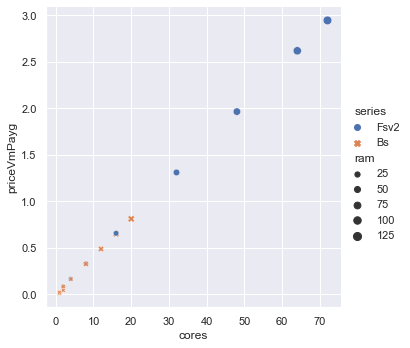

In [109]:
sns.relplot(
    data=vm_pricing_table_offers_x1
        [vm_pricing_table_offers_x1['series'].isin(['Fsv2', 'Bs'])]
        [vm_pricing_table_offers_x1['OS'] == 'linux-'],
    x='cores',
    y='priceVmPayg',
    hue='series',
    style='series',
    size='ram'
)

In [57]:
vm_pricing_table_offers_x1.dtypes

vmName                          object
availableForML                  object
cores                          float64
diskSize                         int64
gpu                             object
isHidden                        object
isVcpu                          object
ram                            float64
series                          object
pricingTypes                    object
offerType                       object
isOnPrem                        object
groups                          object
version                         object
features                        object
has_AMD_processor                 bool
is_PremiumStorageCapable          bool
has_ARM_processor                 bool
is_isolatedSize                   bool
has_blockStoragePerformance       bool
skuVM                           object
OS                              object
priceVmPayg                    float64
priceVmRes                     float64
priceVmPayg_perCore             object
priceVmPayg_perRamGb     

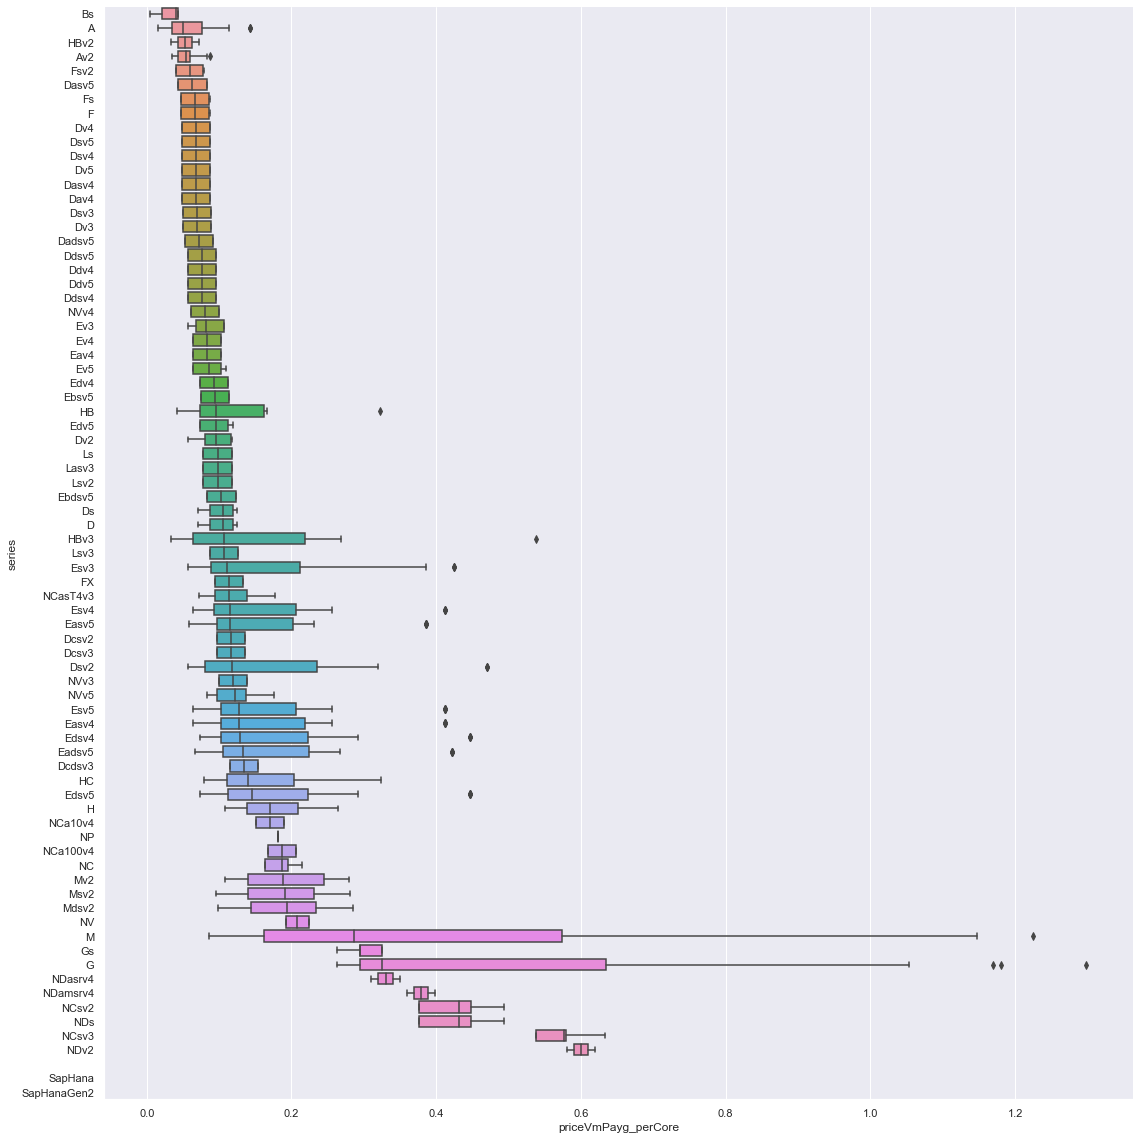

In [90]:
seriesOrdered = list(vm_pricing_table_offers_x1.groupby('series').aggregate('median').sort_values(by='priceVmPayg_perCore').index)
sns.catplot(
    data=vm_pricing_table_offers_x1,
    x='priceVmPayg_perCore',
    y='series',
    kind='box',
    order=seriesOrdered,
    height=16,
    aspect=1
)

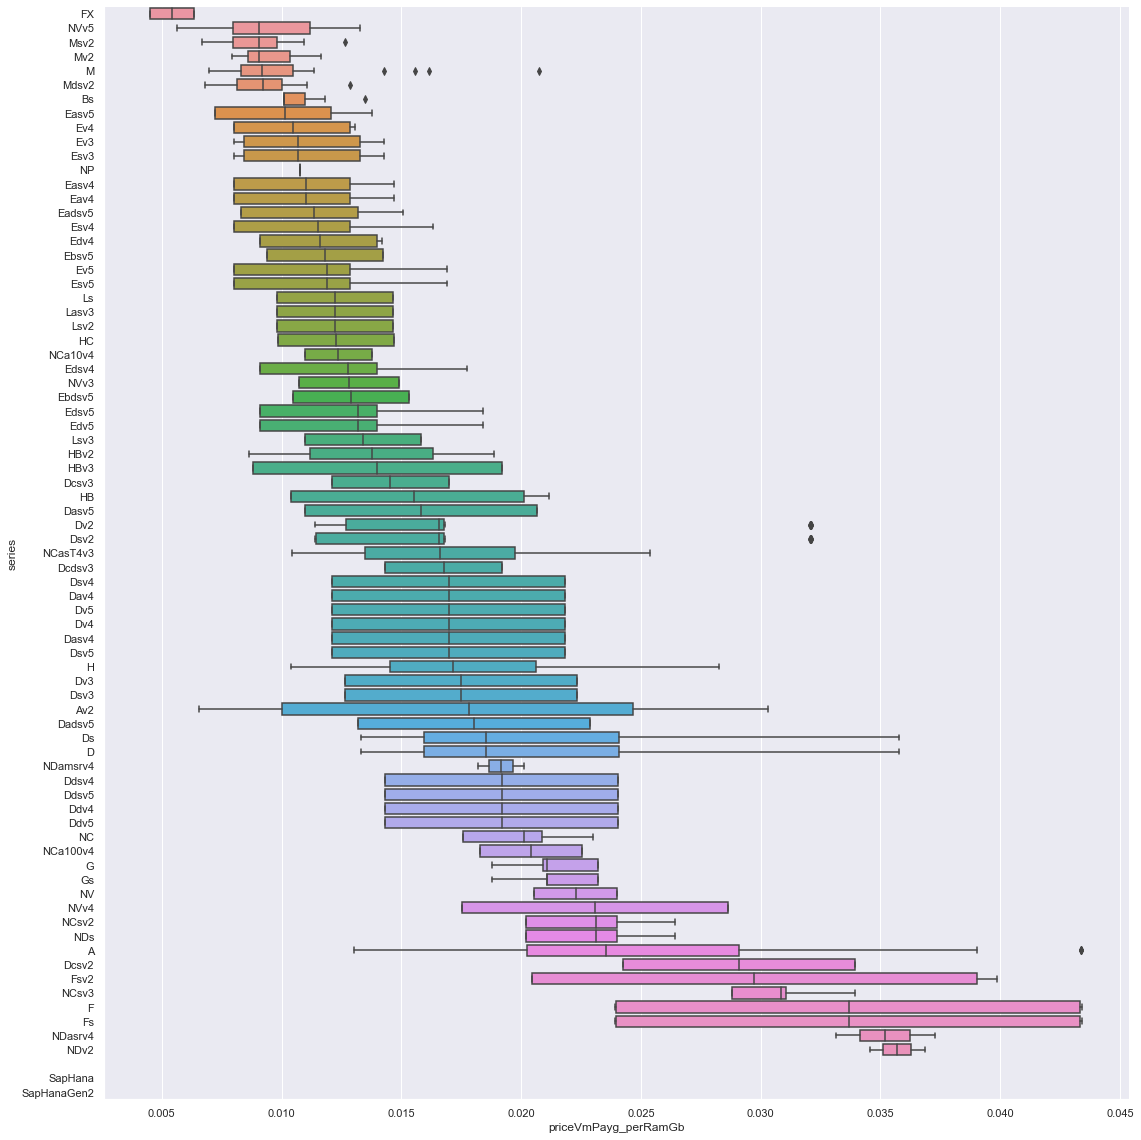

In [93]:
seriesOrdered = list(vm_pricing_table_offers_x1.groupby('series').aggregate('median').sort_values(by='priceVmPayg_perRamGb').index)
sns.catplot(
    data=vm_pricing_table_offers_x1,
    x='priceVmPayg_perRamGb',
    y='series',
    kind='box',
    order=seriesOrdered,
    height=16,
    aspect=1
)

In [30]:
set(vm_pricing_table_offers_x1['series'])

{'',
 'A',
 'Av2',
 'Bs',
 'D',
 'Dadsv5',
 'Dasv4',
 'Dasv5',
 'Dav4',
 'Dcdsv3',
 'Dcsv2',
 'Dcsv3',
 'Ddsv4',
 'Ddsv5',
 'Ddv4',
 'Ddv5',
 'Ds',
 'Dsv2',
 'Dsv3',
 'Dsv4',
 'Dsv5',
 'Dv2',
 'Dv3',
 'Dv4',
 'Dv5',
 'Eadsv5',
 'Easv4',
 'Easv5',
 'Eav4',
 'Ebdsv5',
 'Ebsv5',
 'Edsv4',
 'Edsv5',
 'Edv4',
 'Edv5',
 'Esv3',
 'Esv4',
 'Esv5',
 'Ev3',
 'Ev4',
 'Ev5',
 'F',
 'FX',
 'Fs',
 'Fsv2',
 'G',
 'Gs',
 'H',
 'HB',
 'HBv2',
 'HBv3',
 'HC',
 'Lasv3',
 'Ls',
 'Lsv2',
 'Lsv3',
 'M',
 'Mdsv2',
 'Msv2',
 'Mv2',
 'NC',
 'NCa100v4',
 'NCa10v4',
 'NCasT4v3',
 'NCsv2',
 'NCsv3',
 'NDamsrv4',
 'NDasrv4',
 'NDs',
 'NDv2',
 'NP',
 'NV',
 'NVv3',
 'NVv4',
 'NVv5',
 'SapHana',
 'SapHanaGen2'}

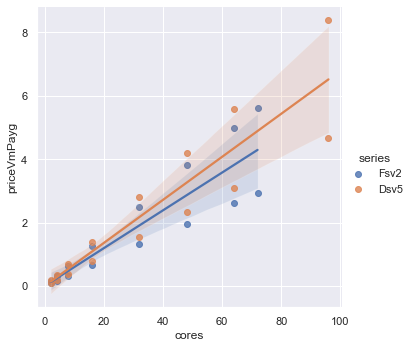

In [95]:
sns.lmplot(
    data=vm_pricing_table_offers_x1[
        vm_pricing_table_offers_x1['series'].isin(['Fsv2', 'Dsv5'])
    ],
    x='cores',
    y='priceVmPayg',
    hue='series'
)